# Coastal flood inundation mapping workflow

### [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/passah2o/pygeoflood/blob/master/doc/examples/c_hand_example.ipynb)

On Google Colab, run the following commands to install pygeoflood and other dependencies:

```bash
%pip install git+https://github.com/passah2o/pygeoflood
%pip install contextily matplotlib-scalebar
```


### Import libraries

In [1]:
from pathlib import Path
from pygeoflood import PyGeoFlood

### Download example data if necessary
Resulting directory structure and file sizes:
```
data
├── aoi_coastline.geojson [5.7M]
└── houston_example_DEM_30m.tif [121M]


In [2]:
%%bash

# places input datasets in data directory whether or not it exists
if [ -d "data" ]; then
  cd data
  curl -sL https://utexas.box.com/shared/static/sx0n3rncb191nuwokqjpmu14yo38pw61.tgz | tar --strip-components=1 -xzvf -
else
  curl -sL https://utexas.box.com/shared/static/sx0n3rncb191nuwokqjpmu14yo38pw61.tgz | tar -xzvf -
fi


x aoi_coastline.geojson
x houston_example_DEM_30m.tif


### Instantiate **pygeoflood** model class


In [3]:
pgf = PyGeoFlood(dem_path="data/houston_example_DEM_30m.tif")

### Show DEM with ocean pixel location

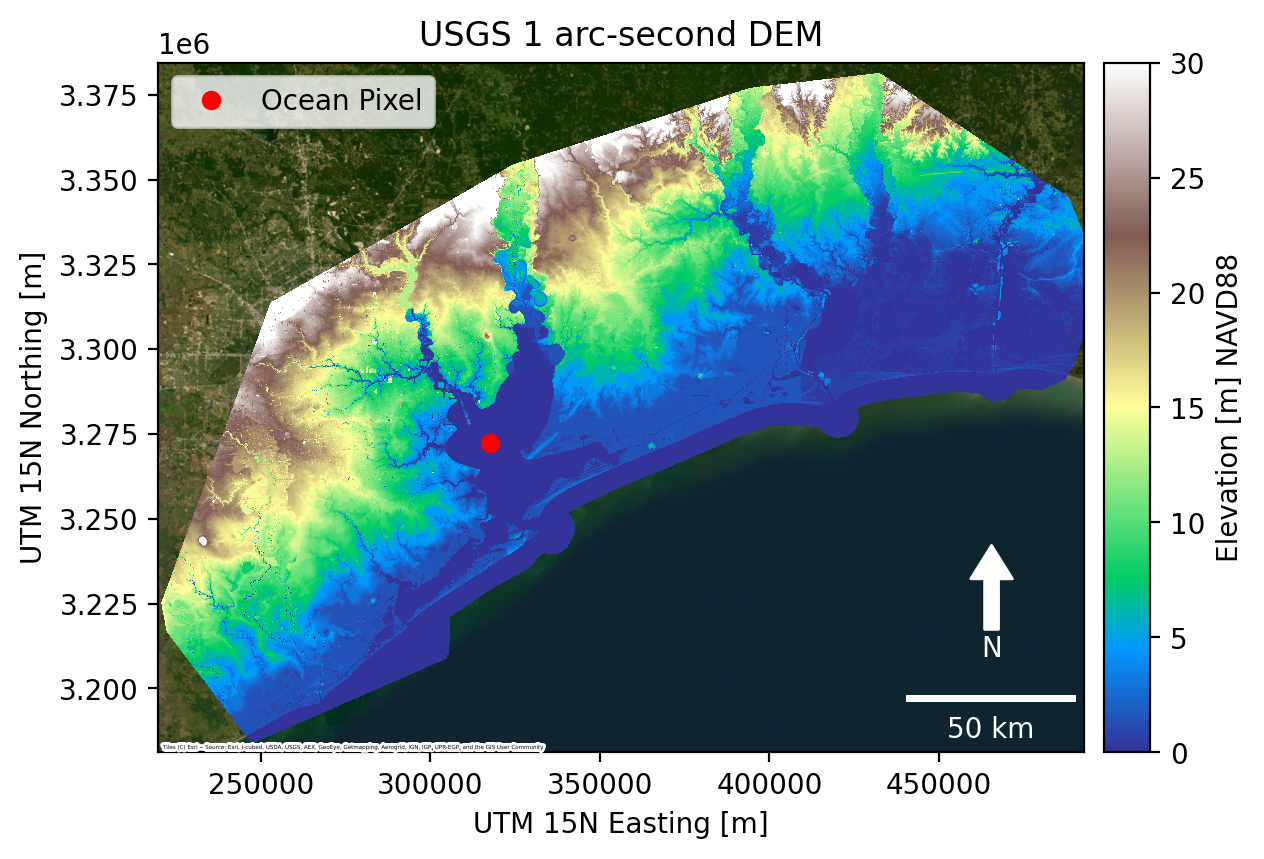

In [4]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio

from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rasterio.features import geometry_mask
from rasterio.plot import plotting_extent
from skimage.measure import label


def plot_raster(raster=None, profile=None, label=None, **kwargs):
    fig, ax = plt.subplots(dpi=200)

    # show inundation map
    im = ax.imshow(
        raster,
        extent=plotting_extent(raster, profile["transform"]),
        zorder=2,
        **kwargs,
    )

    # add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    fig.colorbar(im, cax=cax, label=label)

    # add basemap
    cx.add_basemap(
        ax,
        crs=profile["crs"],
        source=cx.providers.Esri.WorldImagery,
        zoom=10,
        attribution_size=2,
        zorder=1,
    )

    # add scalebar
    ax.add_artist(ScaleBar(1, box_alpha=0, location="lower right", color="white"))

    # add north arrow
    x, y, arrow_length = 0.9, 0.3, 0.15
    ax.annotate(
        "N",
        color="white",
        xy=(x, y),
        xytext=(x, y - arrow_length),
        arrowprops=dict(facecolor="white", edgecolor="white", width=5, headwidth=15),
        ha="center",
        va="center",
        fontsize=10,
        xycoords=ax.transAxes,
    )

    return fig, ax

# 30m DEM of houston to use as example
with rio.open(pgf.dem_path) as ds:
    dem = ds.read(1)
    dem_profile = ds.profile
    dem[dem == dem_profile["nodata"]] = np.nan

# UTM 15N Easting, Northing of a grid cell in the ocean
ocean_E, ocean_N = 317540, 3272260

fig, ax = plot_raster(
    raster=dem,
    profile=dem_profile,
    label="Elevation [m] NAVD88",
    interpolation="nearest",
    vmax=30,
    vmin=0,
    cmap="terrain",
)

ax.plot(ocean_E, ocean_N, "ro", label="Ocean Pixel")

# add labels
ax.legend(loc="upper left")
ax.set(
    title="USGS 1 arc-second DEM",
    xlabel="UTM 15N Easting [m]",
    ylabel="UTM 15N Northing [m]",
)

plt.show()

### run c-HAND

In [5]:
ocean_pixel = (ocean_E, ocean_N)
ike_gage = 3.8  # meters NAVD88
pgf.c_hand(ocean_coords=ocean_pixel, gage_el=ike_gage)

Running c_hand with parameters:
    ocean_coords = (317540, 3272260)
    xy = True
    gage_el = 3.8
    custom_dem = None
    custom_path = None
Coastal inundation raster written to data/houston_example_DEM_30m_coastal_inundation.tif
c_hand completed in 5.5596 seconds



### Crop out coastline and plot coastal inundation map

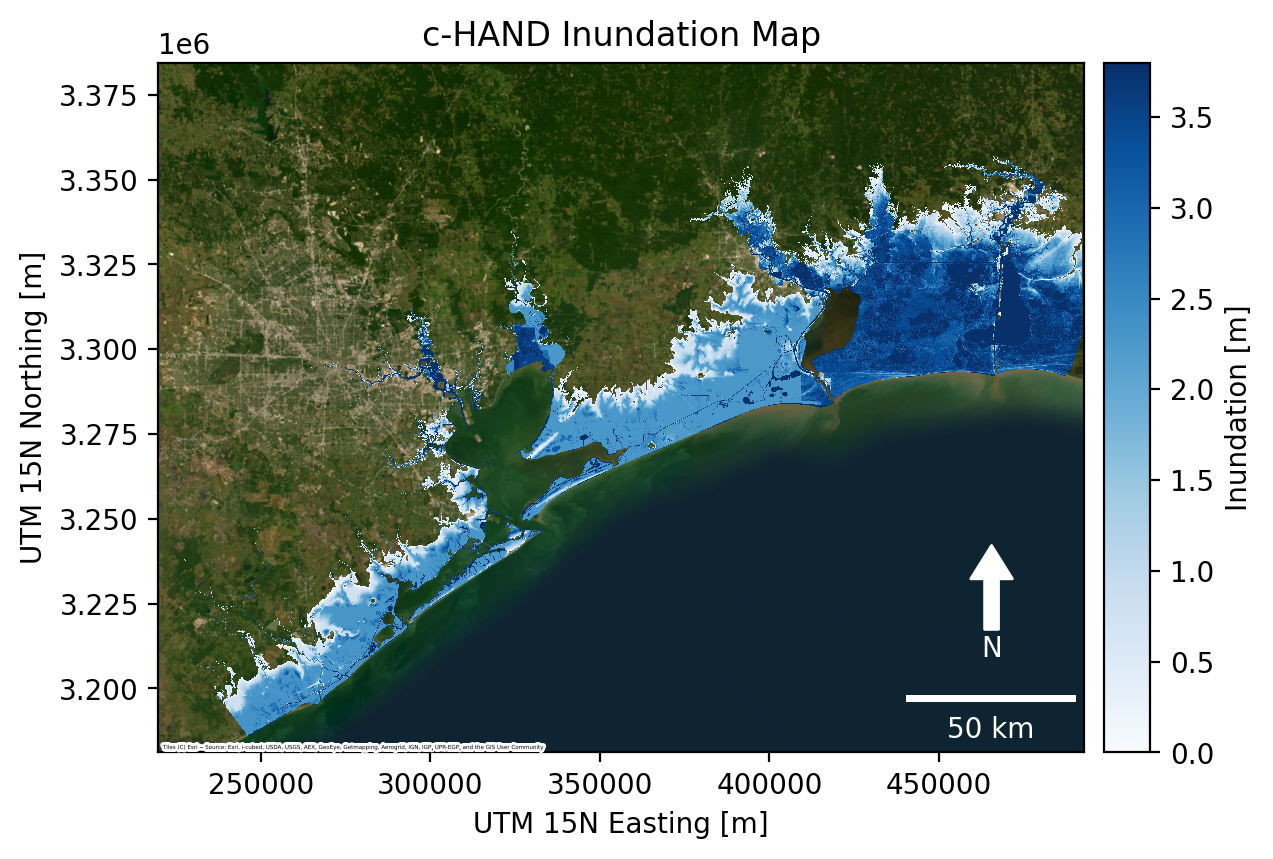

In [6]:
# read coastal inundation map
with rio.open(pgf.coastal_inundation_path) as ds:
    inun_ike = ds.read(1)
    ike_profile = ds.profile

# read geojson or shapefile of domain with coastline
aoi_coast = gpd.read_file(Path("data", "aoi_coastline.geojson"))
aoi_coast_mask = geometry_mask(
    aoi_coast.geometry,
    inun_ike.shape,
    dem_profile["transform"],
)
# crop array to coastline
inun_ike[aoi_coast_mask == True] = np.nan
inun_ike[inun_ike == 0] = np.nan

fig, ax = plot_raster(
    raster=inun_ike,
    profile=ike_profile,
    label="Inundation [m]",
    interpolation="nearest",
    cmap="Blues",
    vmax=ike_gage,
    vmin=0,
)

# add labels
ax.set(
    title="c-HAND Inundation Map",
    xlabel="UTM 15N Easting [m]",
    ylabel="UTM 15N Northing [m]",
)

plt.show()

# save figure
fig.savefig(Path("data", "inun_ike.png"), dpi=200, bbox_inches="tight")